In [4]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import os
from read_O3_LVK_results import *

In [5]:
precomputed_data = "stored_z_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    zs = traces['zs']
    f_zs = traces['f_zs']
    R_ref = traces['R_ref']
    mu_chi = traces['mu_chi']
    logsig_chi = traces['logsig_chi']
    sig_cost = traces['sig_cost']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    z_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_data.npy',allow_pickle=True)[()]
    z_values = z_data['z_allSamples']

    # For ease of plotting, coarse-grain by a factor of 50
    zs = z_values[::50]
    f_zs = samps.f_zs[::50,:]

    traces = {
        'zs':zs,
        'f_zs':f_zs,
        'R_ref':samps['R20'].values,
        'mu_chi':samps['mu_chi'].values,
        'logsig_chi':samps['logsig_chi'].values,
        'sig_cost':samps['sig_cost'].values,
        'bq':samps['bq'].values,
        'alpha':samps['alpha'].values,
        'mu_m1':samps['mu_m1'].values,
        'sig_m1':samps['sig_m1'].values,
        'log_f_peak':samps['log_f_peak'].values,
        'mMin':samps['mMin'].values,
        'mMax':samps['mMax'].values,
        'log_dmMin':samps['log_dmMin'].values,
        'log_dmMax':samps['log_dmMax'].values
        }

    np.save('stored_z_data.npy',traces)

In [3]:
lvk_z_grid,lvk_R_zs = get_lvk_z(100)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:68: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_q_unnormed /= np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3

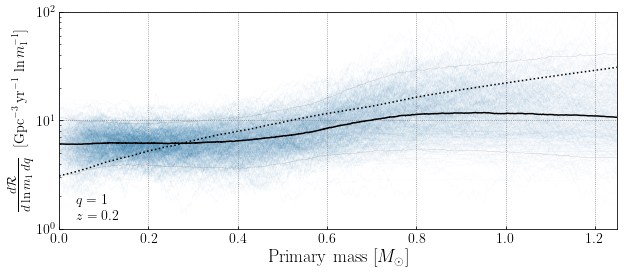

In [4]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

R_zs = R_ref[np.newaxis,:]*f_zs*20.
      
for i in np.random.choice(range(R_zs.shape[1]),size=500,replace=False):                 
    ax.plot(zs,R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(zs,np.median(R_zs,axis=1),color='black')
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.25)
ax.set_ylim(1,100)
ax.set_yscale('log')

ax.plot(lvk_z_grid,np.median(lvk_R_zs,axis=0),color='black',ls=':')

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

#plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.show()

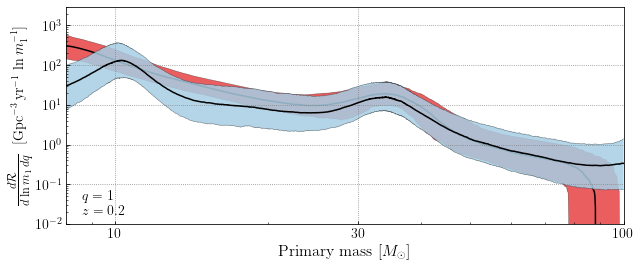

In [5]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

ax.plot(m1s,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.fill_between(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

ax.plot(lvk_m1_grid,np.median(lvk_R_m1s_qs[:,-1,:],axis=0)*lvk_m1_grid,color='black',zorder=-1)
ax.fill_between(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('lnm1_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

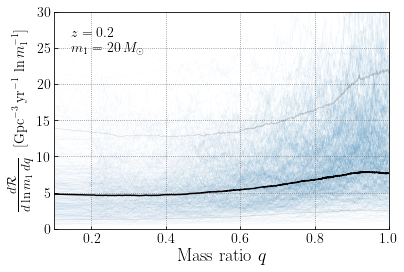

In [70]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

plt.savefig('q_rate.pdf',bbox_inches='tight',dpi=200)
plt.show()

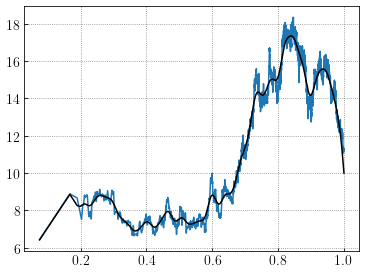

In [171]:
from scipy.ndimage import gaussian_filter

fig,ax = plt.subplots()

ax.plot(qs,dR_dqs_lnm20[:,155])

#kernel = np.exp(-np.subtract.outer(qs,qs)**2/(2.*0.01**2))
#test = kernel*dR_dqs_lnm20[:,75]

extended_qs = np.concatenate([qs,2.-qs])
kernel = np.exp(-np.subtract.outer(extended_qs,extended_qs)**2/(2.*0.01**2))
test = kernel*np.concatenate([dR_dqs_lnm20[:,155],dR_dqs_lnm20[::-1,155]])

ax.plot(qs,(np.sum(test,axis=1)/np.sum(kernel,axis=1))[:qs.size],color='black')

In [179]:
extended_qs = np.concatenate([qs,2.-qs])
kernel = np.exp(-np.subtract.outer(extended_qs,extended_qs)**2/(2.*0.01**2))

ind_q04 = np.argmin(np.abs(qs-0.4))
ind_q05 = np.argmin(np.abs(qs-0.5))
ind_q06 = np.argmin(np.abs(qs-0.6))
ind_q07 = np.argmin(np.abs(qs-0.7))
ind_q08 = np.argmin(np.abs(qs-0.8))
ind_q09 = np.argmin(np.abs(qs-0.9))

nDraws=1000
q_ratios_05 = np.zeros(nDraws)
q_ratios_06 = np.zeros(nDraws)
q_ratios_07 = np.zeros(nDraws)
q_ratios_08 = np.zeros(nDraws)
q_ratios_09 = np.zeros(nDraws)
q_ratios_1 = np.zeros(nDraws)
for i in range(nDraws):
    
    test = kernel*np.concatenate([dR_dqs_lnm20[:,i],dR_dqs_lnm20[::-1,i]]) 
    smoothed_rates = (np.sum(test,axis=1)/np.sum(kernel,axis=1))[:qs.size]
    
    q_ratios_05[i] = smoothed_rates[ind_q05]/smoothed_rates[ind_q04]
    q_ratios_06[i] = smoothed_rates[ind_q06]/smoothed_rates[ind_q04]
    q_ratios_07[i] = smoothed_rates[ind_q07]/smoothed_rates[ind_q04]
    q_ratios_08[i] = smoothed_rates[ind_q08]/smoothed_rates[ind_q04]
    q_ratios_09[i] = smoothed_rates[ind_q09]/smoothed_rates[ind_q04]
    q_ratios_1[i] = smoothed_rates[-1]/smoothed_rates[ind_q04]

0.608


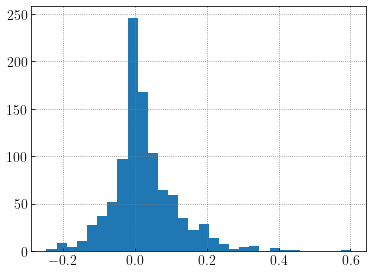

0.688


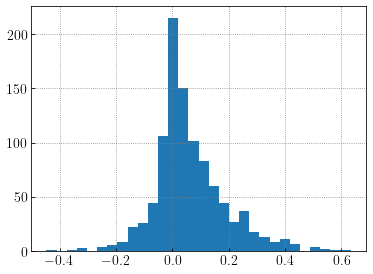

0.756


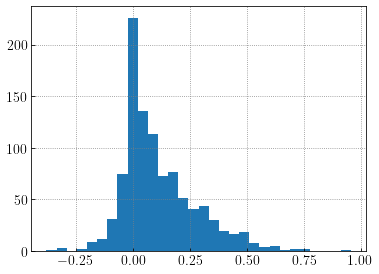

0.814


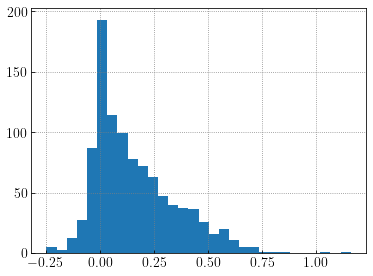

0.854


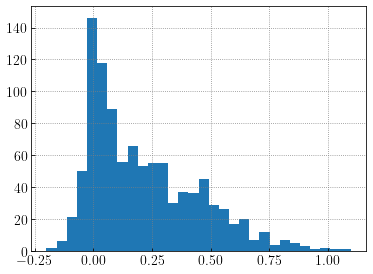

0.828


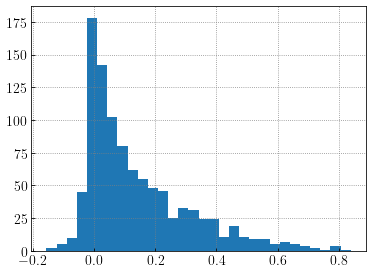

In [180]:
print(q_ratios_05[q_ratios_05>1].size*1./q_ratios_05.size)
plt.hist(np.log10(q_ratios_05),bins=30)
plt.show()

print(q_ratios_06[q_ratios_06>1].size*1./q_ratios_06.size)
plt.hist(np.log10(q_ratios_06),bins=30)
plt.show()

print(q_ratios_07[q_ratios_07>1].size*1./q_ratios_07.size)
plt.hist(np.log10(q_ratios_07),bins=30)
plt.show()

print(q_ratios_08[q_ratios_08>1].size*1./q_ratios_08.size)
plt.hist(np.log10(q_ratios_08),bins=30)
plt.show()

print(q_ratios_09[q_ratios_09>1].size*1./q_ratios_09.size)
plt.hist(np.log10(q_ratios_09),bins=30)
plt.show()

print(q_ratios_1[q_ratios_1>1].size*1./q_ratios_1.size)
plt.hist(np.log10(q_ratios_1),bins=30)
plt.show()

In [193]:
lvk_dR_dq_lnm20.shape,lvk_q_grid.shape

((300, 501), (501,))

1.0


/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_27572/3445562997.py:6: RuntimeWarning: divide by zero encountered in true_divide
  lvk_ratio = lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_27572/3445562997.py:9: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(np.log10(lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]),bins=30)


ValueError: supplied range of [0.865132767548974, inf] is not finite

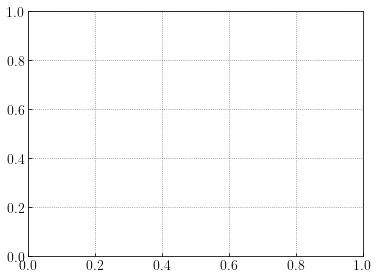

In [194]:
ind_lvk_q05 = np.argmin(np.abs(lvk_q_grid-0.5))

ind_m20 = np.argmin(np.abs(lvk_m1_grid-10.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*10.

lvk_ratio = lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]
print(lvk_ratio[lvk_ratio>1].size*1./lvk_ratio.size)

plt.hist(np.log10(lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]),bins=30)
plt.show()

In [181]:
lvk_dR_dq_lnm20.shape

(300, 501)

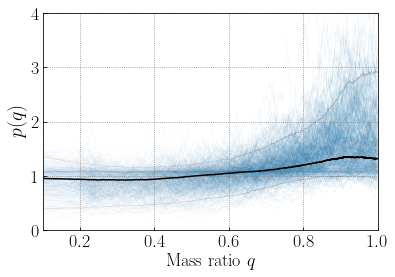

In [57]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

p_qs = dR_dqs_lnm20/np.trapz(dR_dqs_lnm20,qs,axis=0)

for i in np.random.choice(range(p_qs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,4)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q.pdf',bbox_inches='tight',dpi=200)
plt.show()

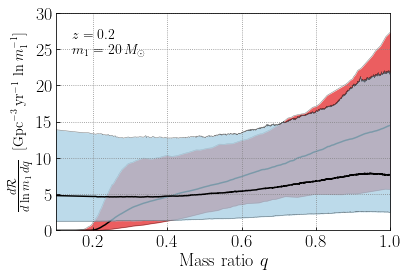

In [199]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.fill_between(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),
                np.quantile(dR_dqs_lnm20,0.95,axis=1),
                color='#a6cee3',lw=0.15,alpha=0.75)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.

ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('q_rate_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

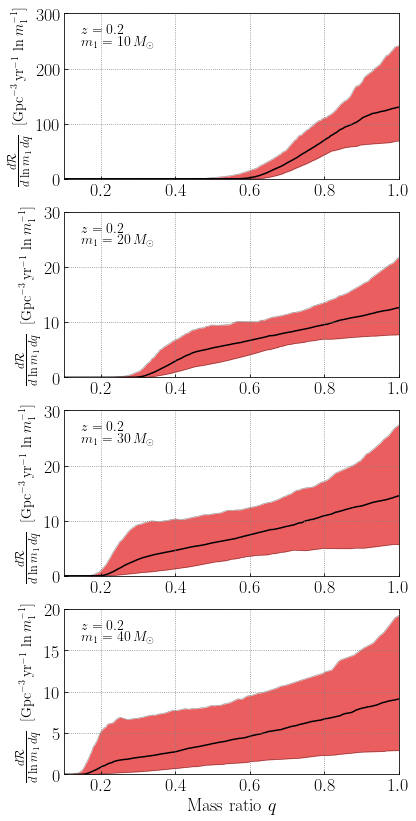

In [11]:
fig = plt.figure(figsize=(6,14))

ax = fig.add_subplot(411)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-10.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*10.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,300)
ax.text(0.05,0.83,r'$m_1=10\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(412)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-20.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*20.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(413)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=30\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(414)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-40.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*40.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,20)
ax.text(0.05,0.83,r'$m_1=40\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Mass ratio $q$',fontsize=18)


plt.savefig('lvk_mass_ratios.pdf',bbox_inches='tight',dpi=200)
plt.show()

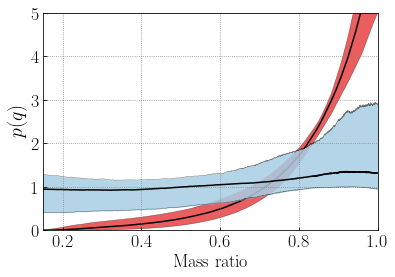

In [66]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.fill_between(qs,np.quantile(p_qs,0.05,axis=1),np.quantile(p_qs,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

lvk_R_qs = np.trapz(lvk_R_m1s_qs,lvk_m1_grid,axis=2)
lvk_p_qs = np.array([lvk_R_qs[i,:]/np.trapz(lvk_R_qs[i,:],lvk_q_grid) for i in range(lvk_R_qs.shape[0])])

ax.plot(lvk_q_grid,np.median(lvk_p_qs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),
                np.quantile(lvk_p_qs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.15,1)
ax.set_ylim(0,5)

ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()